# Random Forest Grid Search Part 1
This script takes in the 10 folds of data and runs a grid search over a set of hyperparameters.

The grid search takes a long time, but it will run in the background on the Google cloud! I used the Google Earth Engine API, but you could also convert to a geopandas dataframe and use a machine learning library like [scikit learn](https://scikit-learn.org/stable/).

In [ ]:
# Accesses Earth Engine API
import ee
ee.Authenticate()
ee.Initialize()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Import 10 folds of data. I split this up in advance to keep the folds consistent across all models.

In [3]:
# import the 10-folds of training and validation data
f0 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f0')
f1 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f1')
f2 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f2')
f3 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f3')
f4 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f4')
f5 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f5')
f6 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f6')
f7 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f7')
f8 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f8')
f9 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f9')

In [4]:
# create 10 training sets (train0 contains all folds except f0)
train0 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f7, f8, f9]).flatten()
train1 = ee.FeatureCollection([f0, f2, f3, f4, f5, f6, f7, f8, f9]).flatten()
train2 = ee.FeatureCollection([f1, f0, f3, f4, f5, f6, f7, f8, f9]).flatten()
train3 = ee.FeatureCollection([f1, f2, f0, f4, f5, f6, f7, f8, f9]).flatten()
train4 = ee.FeatureCollection([f1, f2, f3, f0, f5, f6, f7, f8, f9]).flatten()
train5 = ee.FeatureCollection([f1, f2, f3, f4, f0, f6, f7, f8, f9]).flatten()
train6 = ee.FeatureCollection([f1, f2, f3, f4, f5, f0, f7, f8, f9]).flatten()
train7 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f0, f8, f9]).flatten()
train8 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f7, f0, f9]).flatten()
train9 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f7, f8, f0]).flatten()

### Helper functions

In [ ]:
# Compute the difference between computed pm25 and actual
def difference(feature):
  diff = ee.Number(feature.get('pm_cal')) \
    .subtract(ee.Number(feature.get('pm25')))
  # Return the feature with the squared difference set to the 'diff' property.
  return feature.set('sq_diff', diff.pow(2))

def runModel(feature):
  var = feature.get('var')
  leaf = feature.get('leaf')
  bag = feature.get('bag')
  rf_model = ee.Classifier.smileRandomForest(**{
        'numberOfTrees': 100, # total trees used
        'variablesPerSplit': var, # if unspecified, using 2 or 3
        'minLeafPopulation': leaf, # only trees trained with > this amt of data points
        'bagFraction': bag, # fraction of data sampled for each tree
        'maxNodes': None, # max nodes of tree
        'seed': 0}) \
        .setOutputMode('REGRESSION')\
        .train(**{
          'features': training,
          'classProperty': 'pm25',
          'inputProperties': ['PRES', 'aod', 'RH', 'PBLH', 'DPT', 'WIND', 'WDIR']
      })

  # apply model to validation data and apply to training data
  val_data_applied = validation.classify(rf_model, 'pm_cal')
  train_data_applied = training.classify(rf_model, 'pm_cal')

  # RMSE for validation data
  val_diff = val_data_applied.map(difference)
  val_rmse = ee.Number(val_diff.reduceColumns(ee.Reducer.mean(), ['sq_diff']) \
    .get('mean')).sqrt();

  # RMSE for training data
  train_dif = train_data_applied.map(difference)
  train_rmse = ee.Number(train_dif.reduceColumns(ee.Reducer.mean(), ['sq_diff']) \
    .get('mean')).sqrt();

  return ee.Feature(None, {'var': var, 'leaf': leaf, 'bag': bag, 'train_rmse': train_rmse,
                                      'val_rmse': val_rmse})

### Create an ee.FeatureCollection with hyperparamter options. This is necessary for applying a function to each feature in a collection.

In [ ]:
# feature collection of all the hyperparameter options
options = []
var_list = range(1, 8)
leaf_list = range(1, 11)
bag_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for v in var_list:
  for l in leaf_list:
    for b in bag_list:
      feature = ee.Feature(None, {'var': v, 'leaf': l, 'bag': b})
      options.append(feature)
options_col = ee.FeatureCollection(options)

### Run the grid search across each fold of data

In [9]:
# keys are training and items are testing
folds = {
    train0: f0,
    train1: f1,
    train2: f2,
    train3: f3,
    train4: f4,
    train5: f5,
    train6: f6,
    train7: f7,
    train8: f8,
    train9: f9
}

In [ ]:
all_results = []
count = 0 # keep track of which fold it is
for training in folds:

  # get validation fold
  validation = folds[training]

  # run a grid search on hyperparameters
  fold_result = ee.FeatureCollection(options_col.map(runModel))
  collection = fold_result.set('fold', count)
  all_results.append(collection)

  count += 1

# combine table of all results
table = ee.FeatureCollection(all_results).flatten()

### Export to Google Drive as a csv

In [ ]:
ee.batch.Export.table.toDrive(**{
    'collection': table,
    'description': 'k_fold_results',
    'folder': 'Random_Forest_Iterations',
    'fileNamePrefix': 'k_fold_results_23-11-22'}).start()

# Grid Search Part 2: Best Parameters
Takes in the csv containing all grid search data from part 1 and determines:
* the best parameters
* the best split in data (fold)

### Open results from part 1

In [5]:
# open results in a dataframe
import pandas as pd
kf_results = pd.read_csv('/content/drive/MyDrive/INBRE/Random_Forest_Iterations/k_fold_results_23-11-22.csv')
kf_results['fold'] = kf_results['system:index'].apply(lambda x: x.split('_')[0])
kf_results.drop(axis=1, columns=['system:index', '.geo'], inplace=True)
kf_results.head(3)

,bag,leaf,train_rmse,val_rmse,var,fold
0,0.1,1,10.198835,12.298996,1,0
1,0.2,1,9.168741,11.862113,1,0
2,0.3,1,8.514075,11.760311,1,0


### Determine best hyperparameters and best split in data

In [18]:
# get hyperparameters with best validation rmse
best_rmse = kf_results['val_rmse'].min()
print('Best val rmse: ' + str(best_rmse))

# get train-test split with best validation rmse
min_index = kf_results['val_rmse'].idxmin()
best_row = kf_results.iloc[min_index]
best_leaf = best_row['leaf']
best_bag = best_row['bag']
best_var = best_row['var']

# get average test rmse with these hyperparameters
rows = kf_results.loc[(kf_results['leaf'] == best_leaf) & (kf_results['var'] == best_var) & (kf_results['bag'] == best_bag), :]

# print best parameters and best fold
print('Best leaf: ' + str(best_leaf), ' Best bag: ' + str(best_bag), ' Best var: ' + str(best_var))
print('Best fold: ' + str(best_row.fold))

Best val rmse: 7.035127222464986
Best leaf: 4  Best bag: 0.7  Best var: 2
Best fold: 9


### Iterate through the folds again and run the random forest model using the best parameters

In [10]:
# empty list to hold results
buf_list = []
counter = 0
for training in folds:

  # get validation fold
  validation = folds[training]

  # run random forest with optimal hyperparameters
  rf_model = ee.Classifier.smileRandomForest(**{
        'numberOfTrees': 100,
        'variablesPerSplit': int(best_var),
        'minLeafPopulation': int(best_leaf),
        'bagFraction': float(best_bag),
        'maxNodes': None,
        'seed': 0}) \
        .setOutputMode('REGRESSION')\
        .train(**{
          'features': training,
          'classProperty': 'pm25',
          'inputProperties': ['PRES', 'aod', 'RH', 'PBLH', 'DPT', 'WIND', 'WDIR']
      })

  # apply model to validation data only
  val_data_applied = validation.classify(rf_model, 'pm_cal')
  val_data_applied = val_data_applied.set('fold', counter)
  buf_list.append(val_data_applied)

  # increment counter
  counter += 1

# combine feature collections of results and flatten
val_table = ee.FeatureCollection(buf_list).flatten()

### Export a CSV for calculating other CV metrics using the best hyperparameters.

In [ ]:
# export table of iterations to drive
ee.batch.Export.table.toDrive(**{
    'collection': val_table,
    'description': 'CV_for_coef_of_determination_23-11-22',
    'folder': 'Random_Forest_Iterations',
    'fileNamePrefix': 'CV_for_coef_of_determination_2'}).start()

# Grid Search Part 3: CV Coefficient of Determination

### Import the csv from part 2

In [19]:
table = pd.read_csv('/content/drive/MyDrive/INBRE/Random_Forest_Iterations/CV_for_coef_of_determination_2.csv')
table['fold'] = table['system:index'].apply(lambda x: x.split('_')[0])
table.drop(axis=1, columns=['system:index', 'random'], inplace=True)
table['fold'] = table['fold'].astype('int')
table.head(3)

,DPT,PBLH,PRES,RH,TMP,WDIR,WIND,aod,pm25,pm_cal,station,system:time_start,.geo,fold
0,-4.599997,66.515961,91613.5,67.443287,0.744989,234.100006,0.560,0.008,5.5785,8.089320,Flathead Valley,1325534400000,"{""type"":""Point"",""coordinates"":[-114.189259,48....",0
1,3.100015,1048.556274,91251.0,40.938232,16.414988,156.899994,3.345,0.111,7.4290,6.768099,Flathead Valley,1336500000000,"{""type"":""Point"",""coordinates"":[-114.189259,48....",0
2,14.950006,1964.327759,90336.5,49.528063,26.350000,177.950012,3.450,0.175,11.8460,5.939013,Flathead Valley,1340654400000,"{""type"":""Point"",""coordinates"":[-114.189259,48....",0


### Calculate the cross validated coefficient of determination and RMSE

In [25]:
# get R2 for each fold
def getR2(subtable):
  actual = subtable['pm25']
  pred = subtable['pm_cal']
  mean_actual = actual.mean()
  rss = sum((actual - pred)**2)
  tss = sum((actual - mean_actual)**2)
  return 1 - (rss/tss)

def getRMSE(subtable):
  actual = subtable['pm25']
  pred = subtable['pm_cal']
  sq_diff = sum((actual - pred)**2)
  return np.sqrt(sq_diff/len(subtable))

r2_values = []
rmse_values = []
for i in range(10):
  r2_values.append(getR2(table.loc[table.fold == i, :]))
  rmse_values.append(getRMSE(table.loc[table.fold == i, :]))

r2_vals = pd.DataFrame(r2_values, columns=['r2'])
cv_r2 = r2_vals['r2'].mean()
print('Cross validated r2: ' + str(cv_r2))

rmse_vals = pd.DataFrame(rmse_values, columns=['rmse'])
cv_rmse = rmse_vals['rmse'].mean()
print('Cross validated RMSE: ' + str(cv_rmse))

Cross validated r2: 0.5881294216991102
Cross validated RMSE: 9.637370625429558


In [26]:
# print r2 values across folds
print(r2_vals)

         r2
0  0.597432
1  0.626558
2  0.584107
3  0.606635
4  0.608727
5  0.568558
6  0.494953
7  0.566250
8  0.540411
9  0.687665


In [27]:
# print rmse values across folds
print(rmse_vals)

        rmse
0  10.455987
1   7.838559
2  10.517439
3   8.572972
4   9.490986
5   8.367624
6  14.565168
7  10.202347
8   9.327499
9   7.035127


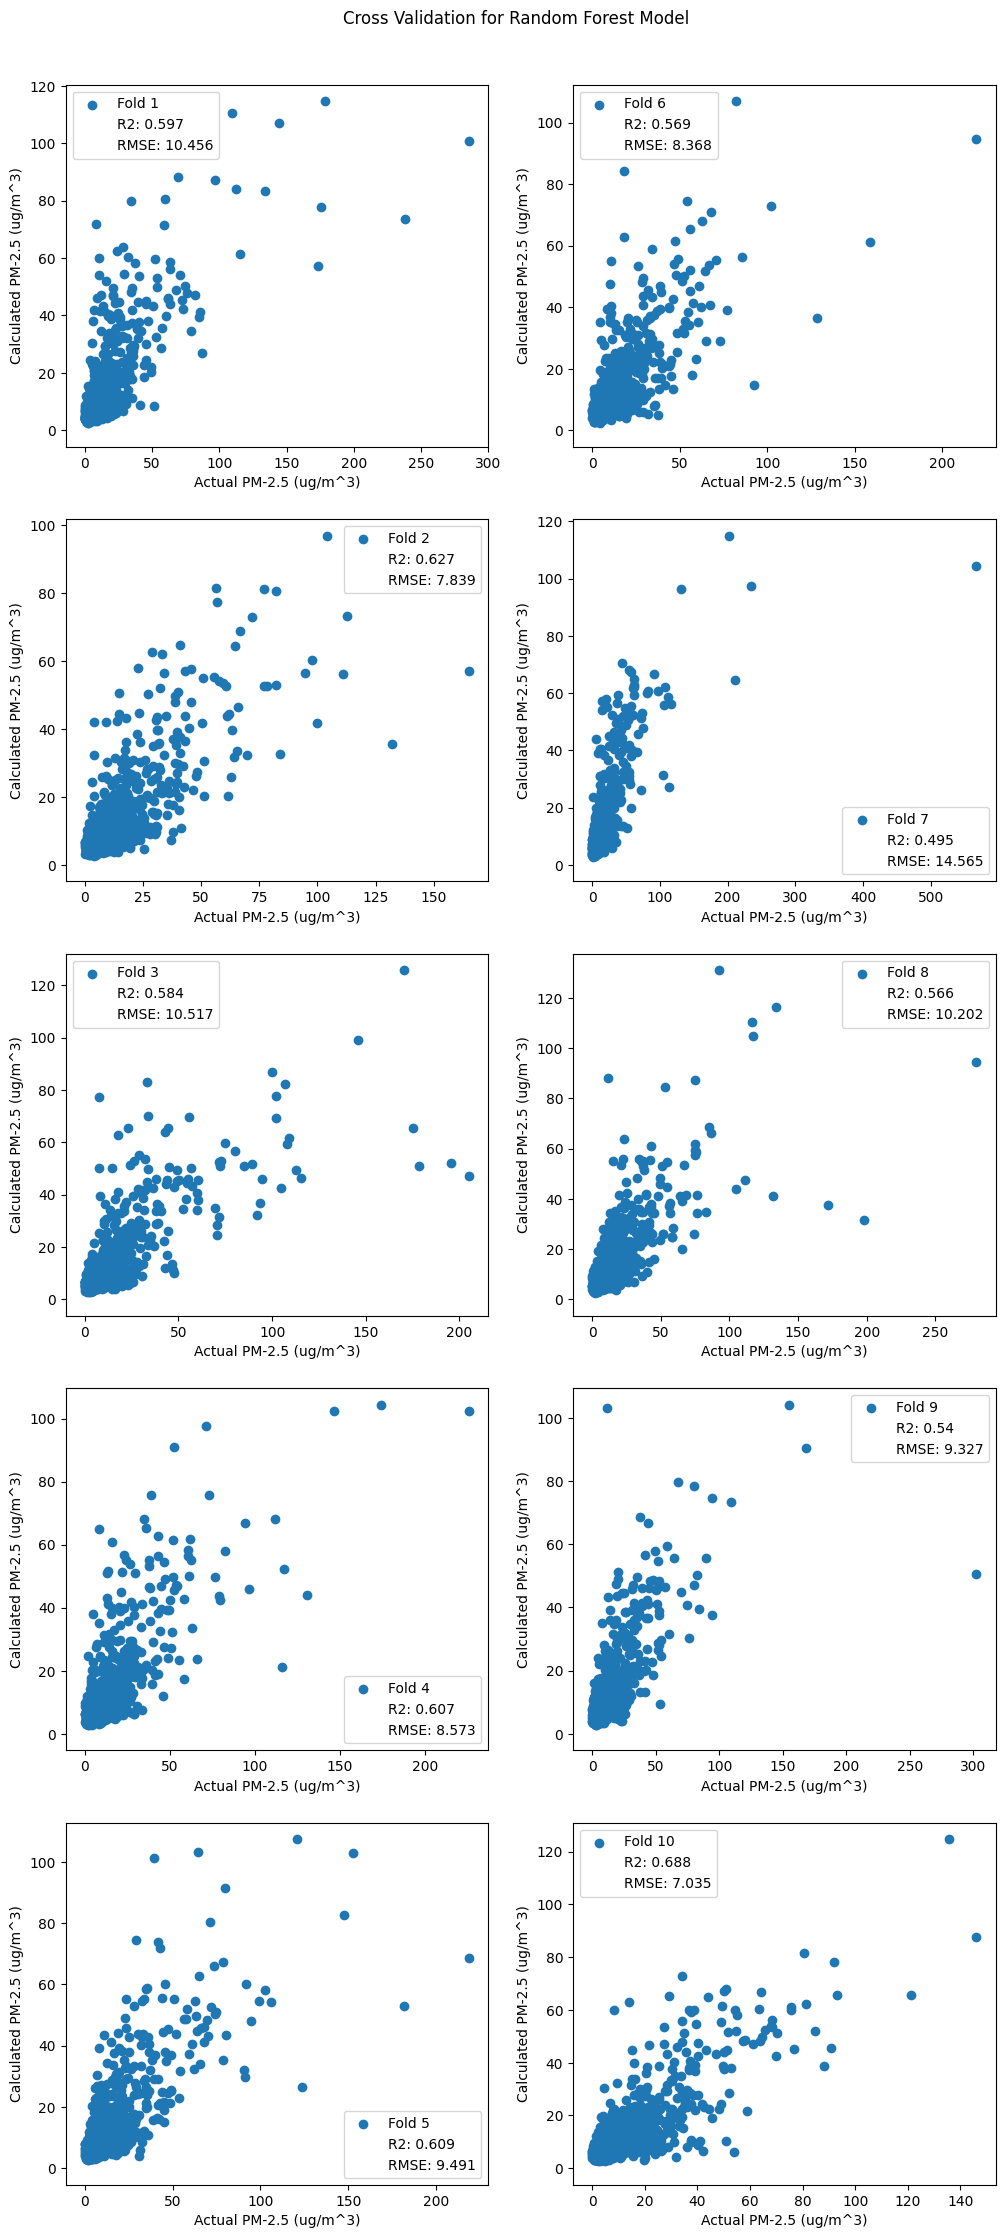

In [28]:
# plot each folds pm25 vs pm_cal on one plot
fig, ax = plt.subplots(5, 2, figsize=(12, 25))
fig.suptitle('Cross Validation for Random Forest Model')
fig.subplots_adjust(top=0.95)
for i in range(0, 10):
  subtable = table.loc[table.fold == i, ['pm25', 'pm_cal']]
  ax[i%5][i//5].scatter(subtable.pm25, subtable.pm_cal, label='Fold ' + str(i+1))
  ax[i%5][i//5].plot(0, 0, alpha=0, label='R2: ' + str(round(r2_vals.iloc[i, 0], 3)))
  ax[i%5][i//5].plot(0, 0, alpha=0, label='RMSE: ' + str(round(rmse_vals.iloc[i, 0], 3)))
  ax[i%5][i//5].set_xlabel('Actual PM-2.5 (ug/m^3)')
  ax[i%5][i//5].set_ylabel('Calculated PM-2.5 (ug/m^3)')
  ax[i%5][i//5].legend()

# save residuals plots
plt.savefig("cv_random_forest.pdf", bbox_inches='tight')

# Grid Search Part 4: Feature Importance

In [29]:
# use the 9th fold which had best results and the best hyperparamters
best_estimator = ee.Classifier.smileRandomForest(**{
    'numberOfTrees': 100, # total trees used
    'variablesPerSplit': int(best_var), # if unspecified, using 2 or 3
    'minLeafPopulation': int(best_leaf), # only trees trained with > this amt of data points
    'bagFraction': float(best_bag), # fraction of data sampled for each tree
    'maxNodes': None, # max nodes of tree
    'seed': 0}) \
        .setOutputMode('REGRESSION')\
        .train(**{
          'features': train9,
          'classProperty': 'pm25',
          'inputProperties': ['PRES', 'aod', 'RH', 'PBLH', 'DPT', 'WIND', 'WDIR']
})

In [30]:
# feature importance
best_estimator.explain().get('importance').getInfo()

{'DPT': 352188440.55912447,
 'PBLH': 290796569.0760698,
 'PRES': 284032012.9983755,
 'RH': 330779185.8862438,
 'WDIR': 214033915.11291242,
 'WIND': 314159547.385064,
 'aod': 627822382.7748703}